# Simulating Hess Diagrams with StarFISH

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %config InlineBackend.figure_format='svg'

import os
import numpy as np

In [2]:
STARFISH = os.getenv("STARFISH")
isoc_dir = "padova_isoc"
lib_dir = "padova_lib"
synth_dir = "wfc3_synth"
fit_dir = "wfc3_fit"

## Download isochrones

The [Padova package](http://github.com/jonathansick/padova) lets us quickly download a set of the Padova group's isochrones from the CMD website. Here we'll download a grid of isochrones to cover a set of WFC3 bands. (*Note: PHAT uses ACS for the optical bands*). Padova is able to export these isochrones into a format that StarFISH understands.

In [3]:
wfc3_bands = ['F275W1', 'F336W', 'F475W', 'F814W', 'F110W', 'F160W']
# z_grid = [0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
#           0.001, 0.0012, 0.0016, 0.002, 0.0025, 0.0031, 0.0039, 0.0049, 0.0061, 0.0077, 0.0096,
#           0.012, 0.015, 0.019, 0.024, 0.03]
# z_grid = [0.015]
z_grid = [0.0096, 0.012, 0.015, 0.019, 0.024, 0.03]

In [4]:
from padova import AgeGridRequest

if not os.path.exists(os.path.join(STARFISH, isoc_dir)):
    for z in z_grid:
        r = AgeGridRequest(z,
                           min_log_age=6.6,
                           max_log_age=10.13,
                           delta_log_age=0.05,
                           phot='wfc3', photsys_version='odfnew')
        for isoc in r.isochrone_set:
            isoc.export_for_starfish(os.path.join(STARFISH, isoc_dir),
                                     bands=wfc3_bands)

In [5]:
from astropy.coordinates import Distance
import astropy.units as u

from starfisher import LibraryBuilder

d = Distance(785 * u.kpc)
builder = LibraryBuilder(isoc_dir, lib_dir,
                         nmag=len(wfc3_bands),
                         dmod=d.distmod.value,
                         iverb=3)
if not os.path.exists(builder.full_isofile_path):
    builder.install()

## Generating a synthetic Hess CMD library

In [6]:
from starfisher import Lockfile, Synth, ExtinctionDistribution, MockNullCrowdingTable, ColorPlane

synth_dir = "wfc3_test/synth"
crowd_path = "wfc3_test/crowding.dat"

# Setup an isochrone locking scheme for 12 age bins
# Only use one metallicity
lockfile = Lockfile(builder.read_isofile(), synth_dir)
lockfile.lock_grid(np.linspace(6.4, 10.5, num=12),
                   z_groups=[('0096', '0120'),
                             ('0150', '0190'),
                             ('0240', '0300')])

# No extinction
young_av = ExtinctionDistribution()
old_av = ExtinctionDistribution()
rel_extinction = np.ones(len(wfc3_bands), dtype=float)
for av in (young_av, old_av):
    av.set_uniform(0.)

# No photometric errors
crowd = MockNullCrowdingTable(crowd_path, len(wfc3_bands))

# Define colour planes to synthesize
opt_cmd = ColorPlane((wfc3_bands.index('F475W'), wfc3_bands.index('F814W')),
                     wfc3_bands.index('F814W'),
                     (-1., 3.),
                     (16., 30.),
                     35.,
                     suffix='f475f814',
                     x_label='F475W-F814W',
                     y_label='F814W')

synth = Synth(synth_dir, builder, lockfile, crowd,
              rel_extinction, young_extinction=young_av, old_extinction=old_av,
              planes=[opt_cmd])
synth.run_synth(n_cpu=4, include_unlocked=False)
synth.plot_all_hess('synth_hess')

/Users/jsick/code/_starfish/starfisher/starfisher/plots.py:25: RuntimeWarning: divide by zero encountered in log10
  hess = np.log10(hess)
/Users/jsick/.virtualenvs/starfish/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


./synth < wfc3_test/synth.0.txt
./synth < wfc3_test/synth.1.txt


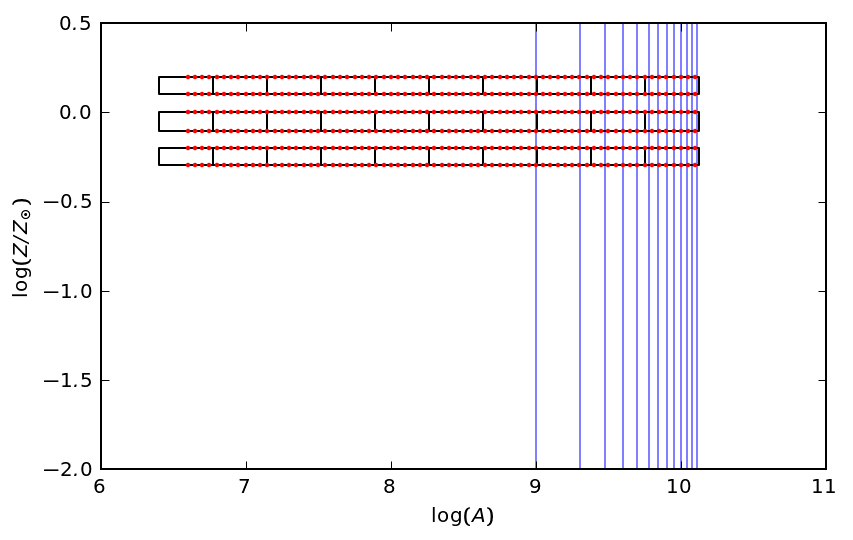

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from starfisher.plots import plot_isochrone_logage_logzsol, plot_lock_polygons

fig = plt.figure(figsize=(6.5, 4), dpi=300)
gs = mpl.gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0])

plot_isochrone_logage_logzsol(ax, builder, marker='.', s=20)
plot_lock_polygons(ax, lockfile, facecolor='None')

for gyr in range(1, 14):
    ax.axvline(np.log10(gyr * 1e9), c='b', alpha=0.5, zorder=-1)

ax.set_xlim(6., 11)
ax.set_ylim(-2, 0.5)
ax.set_xlabel(r"$\log(A)$")
ax.set_ylabel(r"$\log(Z/Z_\odot)$")
fig.show()

In [8]:
for group, multipoly in lockfile.group_polygons.iteritems():
    print "=="
    for verts in multipoly.logage_logzsol_verts:
        print verts

==
[[ 6.4        -0.29648237]
 [ 6.4        -0.19957235]
 [ 6.77272727 -0.19957235]
 [ 6.77272727 -0.29648237]]
==
[[ 6.4        -0.10266234]
 [ 6.4         0.        ]
 [ 6.77272727  0.        ]
 [ 6.77272727 -0.10266234]]
==
[[ 6.4         0.10145764]
 [ 6.4         0.19836765]
 [ 6.77272727  0.19836765]
 [ 6.77272727  0.10145764]]
==
[[ 6.77272727 -0.29648237]
 [ 6.77272727 -0.19957235]
 [ 7.14545455 -0.19957235]
 [ 7.14545455 -0.29648237]]
==
[[ 6.77272727 -0.10266234]
 [ 6.77272727  0.        ]
 [ 7.14545455  0.        ]
 [ 7.14545455 -0.10266234]]
==
[[ 6.77272727  0.10145764]
 [ 6.77272727  0.19836765]
 [ 7.14545455  0.19836765]
 [ 7.14545455  0.10145764]]
==
[[ 7.14545455 -0.29648237]
 [ 7.14545455 -0.19957235]
 [ 7.51818182 -0.19957235]
 [ 7.51818182 -0.29648237]]
==
[[ 7.14545455 -0.10266234]
 [ 7.14545455  0.        ]
 [ 7.51818182  0.        ]
 [ 7.51818182 -0.10266234]]
==
[[ 7.14545455  0.10145764]
 [ 7.14545455  0.19836765]
 [ 7.51818182  0.19836765]
 [ 7.51818182  0.101